In [1]:
import os
import random
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.utils import add_self_loops, degree, remove_self_loops, to_dense_adj, dense_to_sparse
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential
from torch_scatter import scatter
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.data import Batch

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ortho_group
from scipy.io.wavfile import write

import fluidsynth
import mido
import pretty_midi
import networkx as nx


# MIDI file setup tests

In [2]:
def get_midi_length_in_seconds(filename):
    file = pretty_midi.PrettyMIDI(filename)
    length_in_seconds = file.get_end_time()
    return length_in_seconds

def get_midi_sample_rate(filename):
    s = get_midi_length_in_seconds(filename)
    t = get_midi_timesteps(filename)
    return int(t/s)

def get_midi_timesteps(filename):
    midi = mido.MidiFile(filename)
    timesteps = 0
    for track in midi.tracks:
        for msg in track:
            timesteps += msg.time
    return timesteps

TIMESTEPS = get_midi_timesteps("example.midi")
SECS = get_midi_length_in_seconds("example.midi")
SAMPLE_RATE = get_midi_sample_rate("example.midi")
print(TIMESTEPS, SECS, SAMPLE_RATE)

930262 969.0208333333334 960


# Some questions

### First quesion, do we have one piano in all files?
Cool! All of 2018 are right!

In [3]:
# def get_midi_instrument_types(filename):
#     midi = pretty_midi.PrettyMIDI(filename)
#     instrument_types = []
#     for instrument in midi.instruments:
#         # name of the instrument
#         instrument_types.append(pretty_midi.program_to_instrument_name(instrument.program))
#     return instrument_types

# directory = 'maestro-v3.0.0/2018'
# count = 0
# # Loop through all files in the directory and its subdirectories
# for root, dirs, files in os.walk(directory):
#     for file in files:
#         if file.endswith('.midi'):
#             # Read the MIDI file and check its instrument type
#             file_path = os.path.join(root, file)
#             midi_file = pretty_midi.PrettyMIDI(file_path)
#             instrument_types = []
#             for instrument in midi_file.instruments:
#                 # name of the instrument
#                 instrument_types.append(pretty_midi.program_to_instrument_name(instrument.program))
#             if instrument_types != ['Acoustic Grand Piano']:
#                 print("Oops! Error ...")

### Second question, how many buttons (msg.note)s are used?
Here, I want to count the number of different keys used in all MIDI files. I want to build a path graph.

In [4]:
# directory = 'maestro-v3.0.0/2018'
# count_set = set()
# # Loop through all files in the directory and its subdirectories
# for root, dirs, files in os.walk(directory):
#     for file in files:
#         note_values = []
#         if file.endswith('.midi'):
#             # Read the MIDI file and check its instrument type
#             file_path = os.path.join(root, file)
#             midi_file = mido.MidiFile(file_path)
#             for i, track in enumerate(midi_file.tracks):
#                 for msg in track:
#                     if msg.type == 'note_on':
#                         note_values.append(msg.note)
#         count_set.update(note_values)
# expected_set = set(range(21, 109))
# if count_set.issubset(expected_set):
#     print("count_set contains all values from 21 to 108")
# else:
#     print("count_set does not contain all values from 21 to 108")
# print(count_set)

Nice answer! 21 to 108!

like its written here:
https://www.inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies

### Third question, what is the longest timestep generated?
We are going to guess a number for the timestep generated. Are we going to use classification or what?

In [5]:
# directory = 'maestro-v3.0.0/2018'
# count_set = set()
# # Loop through all files in the directory and its subdirectories
# for root, dirs, files in os.walk(directory):
#     for file in files:
#         note_times = []
#         if file.endswith('.midi'):
#             # Read the MIDI file and check its instrument type
#             file_path = os.path.join(root, file)
#             midi_file = mido.MidiFile(file_path)
#             for i, track in enumerate(midi_file.tracks):
#                 for msg in track:
#                     if msg.type == 'note_on':
#                         note_times.append(msg.time)
#         count_set.update(note_times)
# print(max(count_set))

5978 was the longest timestep.

# Generating test/train/val dataset
The first step is to generate the dataset.
I am going to use one single audio file with 15k tuples and keys pressed. We'll train based on first 5k, val on 2nd 5k, and train one the last 5k.

In [6]:
# Load the MIDI file
file = mido.MidiFile('example.midi')
msg_cnt = 0
data_tuples = []
for i, track in enumerate(file.tracks):
    print('Track {}: {}'.format(i, track.name))
    for msg in track:
        if msg.type == 'note_on':
            note_tuple = (msg.note - 20, msg.velocity, msg.time)
            data_tuples.append(note_tuple)
            msg_cnt += 1
    print(msg_cnt)

velocity_values = [t[1] for t in data_tuples]
timestep_values = [t[2] for t in data_tuples]

velocity_mean = np.mean(velocity_values)
velocity_std = np.std(velocity_values)
timestep_mean = np.mean(timestep_values)
timestep_std = np.std(timestep_values)

data_tuples = [(t[0], (t[1] - 0) / velocity_std, (t[2] - 0) / timestep_std) for t in data_tuples]

Track 0: 
0
Track 1: 
15788


## Creating the graph and edge features

In [7]:
def create_piano_graph(num_nodes):
    edges = [(i, i + 1) for i in range(1, num_nodes - 1)] + [(i + 1, i) for i in range(1, num_nodes - 1)]
    edges += [(0, i) for i in range(1, num_nodes)] + [(i, 0) for i in range(1, num_nodes)]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    edge_features = [1] * (len(edges) - 2 * (num_nodes - 1)) + [0] * (2 * (num_nodes - 1))
    edge_attr = torch.tensor(edge_features, dtype=torch.float).view(-1, 1)
    
    return edge_index, edge_attr

In [8]:
num_nodes = 89
sequence_length = 89
edge_index, edge_attr = create_piano_graph(num_nodes)
x = torch.zeros((len(data_tuples), num_nodes, sequence_length), dtype=torch.float)

In [9]:
for i, (note, velocity, timestep) in enumerate(data_tuples):
    if i > 0:
        x[i, :, :-1] = x[i-1, :, 1:]  # Shift all rows one to the front
        x[i, :, -1] = x[i-1, :, -1]
    # Normalize velocity and timestep    
    x[i, note, -1] = velocity
    x[i, 0, -1] = timestep
for i, (note, velocity, timestep) in enumerate(data_tuples):
    for j in range(num_nodes):
      x[i,j,-1] = j

In [10]:
graph_data_list = []

for i in range(len(x) - 1):
    data = Data(x=x[i], edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor([data_tuples[i + 1]], dtype=torch.long))
    graph_data_list.append(data)
train_dataset = graph_data_list[:50]
val_dataset = graph_data_list[50:100]
test_dataset = graph_data_list[100:150]

C:\Users\alike\AppData\Local\Temp\ipykernel_24336\1811185282.py:4: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = Data(x=x[i], edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor([data_tuples[i + 1]], dtype=torch.long))


In [11]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Coding the model

In [12]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=1, aggr='add'):
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)
    
    def aggregate(self, inputs, index):
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

In [13]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=sequence_length, edge_dim=1, out_dim=3):
        super().__init__()
        
        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)
        
        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred_1 = Linear(emb_dim, 88)  # For notes
        self.lin_pred_2 = Linear(emb_dim, 1)  # For velocity
        self.lin_pred_3 = Linear(emb_dim, 1)  # For time
        self.relu = nn.ReLU()
        
    def forward(self, data):
        h = self.lin_in(data.x)  # (n, d_n) -> (n, d)

        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr)  # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch)  # (n, d) -> (batch_size, d)

        out_1 = self.lin_pred_1(h_graph)  # (batch_size, d) -> (batch_size, 88)
        out_2 = self.relu(self.lin_pred_2(h_graph))  # (batch_size, d) -> (batch_size, 128)
        out_3 = self.relu(self.lin_pred_3(h_graph))  # (batch_size, d) -> (batch_size, 1)
        
        return torch.cat((out_1, out_2, out_3), dim=1)

In [14]:
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.
def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss_1 = F.cross_entropy(y_pred[:, :88], data.y[:, 0].long())
        loss_2 = F.mse_loss(y_pred[:, 88:89].squeeze(), data.y[:, 1].float())
        loss_3 = F.mse_loss(y_pred[:, 89:].squeeze(), data.y[:, 2].float())
        loss = loss_1 + loss_2 + loss_3
        # print("NEW--------------")
        # print()
        # print(y_pred[:, 88:89].squeeze())
        # print(data.y[:, 1].float())
        # print()
        # print(y_pred[:, 89:].squeeze())
        # print(data.y[:, 2].float())
        # print()
        # print(loss_1, loss_2, loss_3)
        # break
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def eval(model, loader, device):
    model.eval()
    error = [0, 0, 0]

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            error_1 = F.cross_entropy(y_pred[:, :88], data.y[:, 0], reduction='sum').item()
            error_2 = (F.mse_loss(y_pred[:, 88:89].squeeze(), data.y[:, 1].float())).abs().sum().item()
            print(error)
            error_3 = (F.mse_loss(y_pred[:, 89:].squeeze(), data.y[:, 2].float())).abs().sum().item()
            error = [x + y for x, y in zip(error, [error_1, error_2, error_3])]
    error = [x / len(loader.dataset) for x in error]
    return error

In [15]:
def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):
    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)

    print("\nStart training:")
    best_val_error = [None, None, None]
    perf_per_epoch = []  # Track Test/Val errors vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs + 1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)

        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)

        if any(best is None or err <= best for err, best in zip(val_error, best_val_error)):
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val Errors: {[f"{x:.7f}" for x in val_error]}, '
                  f'Test Errors: {[f"{x:.7f}" for x in test_error]}')

        scheduler.step(sum(val_error) / len(val_error))
        perf_per_epoch.append((test_error[0],test_error[1], test_error[2], val_error[0], val_error[1], val_error[2], epoch, model_name))

    
    t = time.time() - t
    train_time = t / 60
    print(f"\nDone! Training took {train_time:.2f} mins. "
          f"Best validation errors: {[f'{x:.7f}' for x in best_val_error]}, "
          f"corresponding test errors: {[f'{x:.7f}' for x in test_error]}.")
    
    return best_val_error, test_error, train_time, perf_per_epoch

In [16]:
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=sequence_length, edge_dim=1, out_dim=3)
model_name = type(model).__name__
best_val_errors, test_errors, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=10
)

Running experiment for MPNNModel, training on 50 samples for 10 epochs.

Model architecture:
MPNNModel(
  (lin_in): Linear(in_features=20, out_features=64, bias=True)
  (convs): ModuleList(
    (0-3): 4 x MPNNLayer(emb_dim=64, aggr=add)
  )
  (lin_pred_1): Linear(in_features=64, out_features=88, bias=True)
  (lin_pred_2): Linear(in_features=64, out_features=1, bias=True)
  (lin_pred_3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)
Total parameters: 108826

Start training:
[0, 0, 0]
[307.36981201171875, 0.8066571950912476, 0.7752224802970886]
[0, 0, 0]
[280.1942138671875, 0.6407591104507446, 1.8866729736328125]
[0, 0, 0]
[277.45159912109375, 0.5463994741439819, 0.8125]
[0, 0, 0]
[259.468994140625, 0.2788352370262146, 2.0]
[0, 0, 0]
[244.1533203125, 0.8437503576278687, 0.8125]
[0, 0, 0]
[237.96163940429688, 0.5308716893196106, 2.0]
[0, 0, 0]
[214.33685302734375, 0.84375, 0.8125]
[0, 0, 0]
[220.87384033203125, 0.53125, 2.0]
[0, 0, 0]
[192.8194580078125, 0.84375, 0.

In [ ]:
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test Errors 1", "Test Errors 2", "Test Errors 3", "Val Errors 1", "Val Errors 2", "Val Errors 3", "Epoch", "Model"])

RESULTS[model_name] = (best_val_errors, test_errors, train_time)

df_temp = pd.DataFrame(perf_per_epoch, columns=["Test Errors 1", "Test Errors 2", "Test Errors 3", "Val Errors 1", "Val Errors 2", "Val Errors 3", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

<ipython-input-18-d98b3f66e689>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


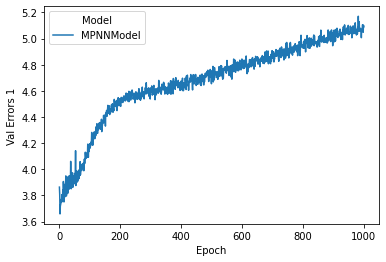

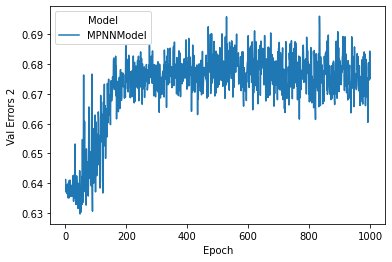

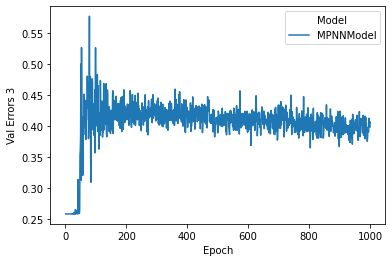

In [ ]:
# Plots for each output
for i in range(3):
    p = sns.lineplot(x="Epoch", y=f"Val Errors {i+1}", hue="Model", data=DF_RESULTS)
    plt.show()

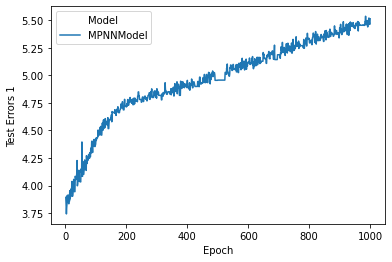

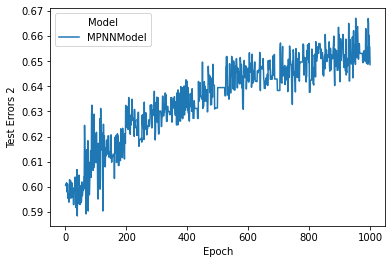

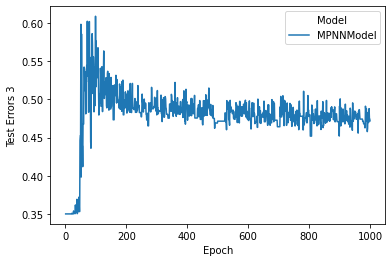

In [ ]:
for i in range(3):
    p = sns.lineplot(x="Epoch", y=f"Test Errors {i+1}", hue="Model", data=DF_RESULTS)
    plt.show()

In [ ]:
test_this = 6
example_data = graph_data_list[test_this]

# Create a batch object for the single example
batch = Batch.from_data_list([example_data])

# Ensure the model is in evaluation mode
model.eval()

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device} Device???")
# Move the batch to the same device as the model
batch = batch.to(device)

# Obtain the model predictions
predictions = model(batch)
print(predictions.shape)

note_logits = predictions[:, :88]
velocity_logits = predictions[:, 88] * velocity_std + velocity_mean
integer_logits = predictions[:, 89] * timestep_std + timestep_mean

# Get the predicted classes for note and velocity
note_predictions = torch.argmax(note_logits, dim=1)
velocity_predictions = torch.round(velocity_logits)

# Get the integer value
integer_predictions = torch.round(integer_logits)

# Print the predictions
print("Note predictions:", note_predictions)
print("Velocity predictions:", velocity_predictions)
print("Integer predictions:", integer_predictions)

print(graph_data_list[test_this + 1].y)

cuda Device???
torch.Size([1, 90])
Note predictions: tensor([42], device='cuda:0')
Velocity predictions: tensor([54.], device='cuda:0', grad_fn=<RoundBackward0>)
Integer predictions: tensor([38.], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[42,  0,  1]])


In [ ]:
def generate_next_tuple(model, data):
    # Create a batch object for the single example
    batch = Batch.from_data_list([data])

    # Ensure the model is in evaluation mode
    model.eval()

    # Move the batch to the same device as the model
    batch = batch.to(device)

    # Obtain the model predictions
    predictions = model(batch)

    note_logits = predictions[:, :88]
    velocity_logits = predictions[:, 88] * velocity_std + velocity_mean
    integer_logits = predictions[:, 89] * timestep_std + timestep_mean
    # print(predictions[:, 89])
    # Get the predicted classes for note and velocity
    note_predictions = torch.argmax(note_logits, dim=1)
    velocity_predictions = torch.round(velocity_logits)

    # Get the integer value
    integer_predictions = torch.round(integer_logits)
    # print(integer_predictions.item())
    # Create the new tuple
    new_tuple = (note_predictions.item(), velocity_predictions.item(), integer_predictions.item())
    return new_tuple


# Start with the desired index
test_this = 50
example_data = graph_data_list[test_this]

# Define the device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of iterations for the loop
num_iterations = 500

# List to store the generated tuples
generated_tuples = []

# Loop to generate new tuples
for _ in range(num_iterations):
    next_tuple = generate_next_tuple(model, example_data)
    generated_tuples.append(next_tuple)

    # Create a new Data object with the next_tuple
    new_data_tuples = example_data.x.numpy()
    new_data_tuples = np.roll(new_data_tuples, -1, axis=1)
    new_data_tuples[:, -1] = new_data_tuples[:, -2]
    new_data_tuples[next_tuple[0], -1] = next_tuple[1]
    new_data_tuples[0, -1] = next_tuple[2]
    example_data = Data(x=torch.tensor(new_data_tuples, dtype=torch.float), edge_index=example_data.edge_index,
                        edge_attr=example_data.edge_attr)

print("Generated tuples:", generated_tuples)
for i in generated_tuples:
  print(i)


Generated tuples: [(58, 35.0, 43.0), (51, 35.0, 1134.0), (51, 35.0, 9643.0), (51, 35.0, 98360.0), (51, 35.0, 1071373.0), (51, 35.0, 10980661.0), (51, 35.0, 119485112.0), (51, 35.0, 1224367232.0), (51, 35.0, 13322715136.0), (51, 35.0, 136514035712.0), (51, 35.0, 1485483278336.0), (51, 35.0, 15220983463936.0), (51, 35.0, 165631840223232.0), (51, 35.0, 1697100224004096.0), (51, 35.0, 1.846798141567795e+16), (51, 35.0, 1.8922297902288077e+17), (51, 35.0, 2.0591799450279608e+18), (51, 35.0, 2.1097840331114676e+19), (51, 35.0, 2.295981885248357e+20), (51, 35.0, 2.3523487270782936e+21), (51, 35.0, 2.5600180657031555e+22), (51, 35.0, 2.622799685660581e+23), (51, 35.0, 2.8544255430749716e+24), (51, 35.0, 2.9243445830140043e+25), (51, 35.0, 3.1826997653854406e+26), (51, 35.0, 3.2605552817662e+27), (51, 35.0, 3.5486992681260657e+28), (51, 35.0, 3.635402011198882e+29), (51, 35.0, 3.95680181610903e+30), (51, 35.0, 4.0533720799519574e+31), (51, 35.0, 4.411833769575989e+32), (51, 35.0, 4.519389172410

In [ ]:
# Create a new MIDI file
new_midi_file = mido.MidiFile()

# Create a new track for the MIDI file
new_track = mido.MidiTrack()
new_midi_file.tracks.append(new_track)

# Iterate over the generated tuples and add note_on messages to the track
for note, velocity, time in generated_tuples:
    new_track.append(mido.Message('note_on', note=note + 20, velocity=int(velocity), time=int(time)))

# Save the new MIDI file
new_midi_file.save('generated_midi.mid')

ValueError: ignored